In [ ]:
import tensorflow as tf
from hyperopt import hp
import pickle
from collections import defaultdict
import pandas as pd

In [ ]:
with open("./classiccontrol_trials.p", "rb") as f:
  trials = pickle.load(f)
print(trials)

In [ ]:
print(trials.trials)
print(trials.results)
print(trials.losses())
print(trials.statuses())

In [ ]:
def create_search_space():
    search_space = {
        "activation": hp.choice("activation", ["relu"]),
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                # "lecun_uniform",
                # "lecun_normal",
                "orthogonal",
                "variance_baseline",
                "variance_0.1",
                "variance_0.3",
                "variance_0.8",
                "variance_3",
                "variance_5",
                "variance_10",
            ],
        ),
        "learning_rate": hp.choice(
            "learning_rate", [0.1, 0.01, 0.001, 0.0001, 0.00001]
        ),  #
        "adam_epsilon": hp.choice(
            "adam_epsilon",
            [0.3125, 0.03125, 0.003125, 0.0003125, 0.00003125, 0.000003125],
        ),
        "clipnorm": hp.choice(
            "clipnorm", [None, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
        ),
        # NORMALIZATION?
        "transfer_interval": hp.choice(
            "transfer_interval", [10, 25, 50, 100, 200, 400, 800, 1600, 2000]
        ),
        "minibatch_size": hp.choice("minibatch_size", [2**i for i in range(3, 8)]),
        "replay_buffer_size": hp.choice(
            "replay_buffer_size",
            [2000, 3000, 5000, 7500, 10000, 15000, 20000, 25000, 50000, 100000],
        ),
        "actor_buffer_size": hp.choice(
            "actor_buffer_size", [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
        ),
        "min_replay_buffer_size": hp.choice(
            "min_replay_buffer_size",
            [125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000],
        ),
        "n_step": hp.choice("n_step", [1, 2, 3, 4, 5, 8, 10]),
        "discount_factor": hp.choice("discount_factor", [0.9, 0.99, 0.995, 0.999]),
        "atom_size": hp.choice("atom_size", [41, 51, 61, 71, 81]),  #
        "width": hp.choice("width", [32, 64, 128, 256, 512, 1024]),
        "dense_layers": hp.choice("dense_layers", [0, 1, 2, 3, 4]),
        # REWARD CLIPPING
        "loss_function": hp.choice(
            "loss_function",
            [tf.keras.losses.CategoricalCrossentropy(), tf.keras.losses.KLDivergence()],
        ),
        "advantage_hidden_layers": hp.choice(
            "advantage_hidden_layers", [0, 1, 2, 3, 4]
        ),  #
        "value_hidden_layers": hp.choice("value_hidden_layers", [0, 1, 2, 3, 4]),  #
        "per_epsilon": hp.choice(
            "per_epsilon", [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
        ),
        "per_alpha": hp.choice("per_alpha", [0.05 * i for i in range(0, 21)]),
        "per_beta": hp.choice("per_beta", [0.05 * i for i in range(1, 21)]),
        "push_params_interval": hp.choice(
            "push_params_interval", [2, 3, 4, 5, 8, 10, 12]
        ),
        "updates_queue_size": hp.choice(
            "updates_queue_size", [1, 2, 3, 4, 5, 8, 10, 12]
        ),
        "samples_queue_size": hp.choice(
            "samples_queue_size", [1, 2, 3, 4, 5, 8, 10, 12]
        ),
        # "remove_old_experiences_interval": hp.choice(
        #     "remove_old_experiences_interval", [1000, 2000, 3000, 4000, 5000, 8000, 10000]
        # ),
        "poll_params_interval": hp.choice("poll_params_interval", [50, 100, 200, 300]),
        "actors_initial_sigma": hp.choice(
            "actors_initial_sigma", [0.1 * i for i in range(1, 10)]
        ),
        "actors_sigma_alpha": hp.choice(
            "actors_sigma_alpha", [i for i in range(1, 20)]
        ),
        "learner_noisy_sigma": hp.choice(
            "learner_noisy_sigma", [0.1 * i for i in range(1, 10)]
        ),
        "num_actors": hp.choice("num_actors", [i for i in range(1, 16 + 1)]),
        # 'per_beta_increase': hp.uniform('per_beta_increase', 0, 0.015),
        # 'search_max_depth': 5,
        # 'search_max_time': 10,
    }
    initial_best_config = []

    return search_space, initial_best_config

ss, ibc = create_search_space()

ss_mod = defaultdict(list)
for k in ss:
    for apply in ss[k].inputs():
        if hasattr(apply, "obj"):
            ss_mod[k].append(apply.obj)

for k,v in ss_mod.items():
    print(f"{k:25} ({len(v):-2}): {v}")

In [ ]:
values_dict = defaultdict(list)
scores = list()

i = 0
for trial in trials.trials:
  vals_idxs_dict = trial["misc"]["vals"]
  for k, v in vals_idxs_dict.items():
    idx = v[0]
    ss_val = ss_mod[k][v[0]]
    values_dict[k].append(ss_val)
  score = -trial["result"]["loss"]
  scores.append(score)

for k, v in values_dict.items():
  print(f"{k:25}: {v}")

df = pd.DataFrame(values_dict)
x_cols = df.columns
df["scores"] = scores

for col in x_cols:
  if col == "loss_function":
    continue
  df.plot(x=col, y="scores", kind="scatter")




/home/ezrahuang/miniconda3/envs/ml/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


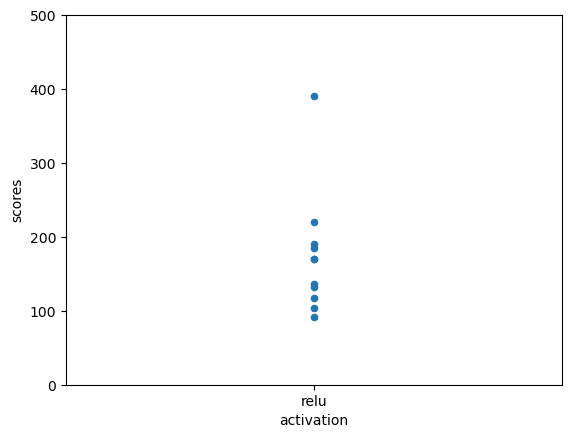

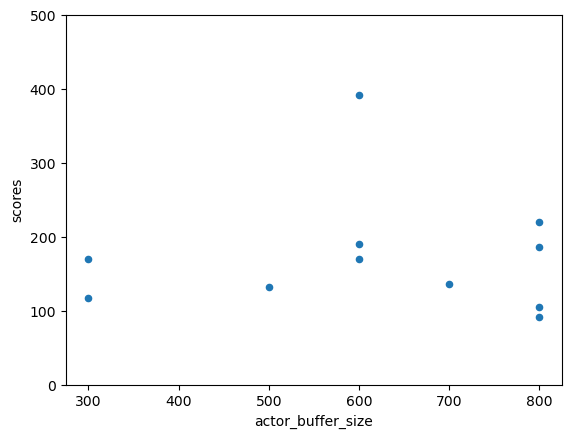

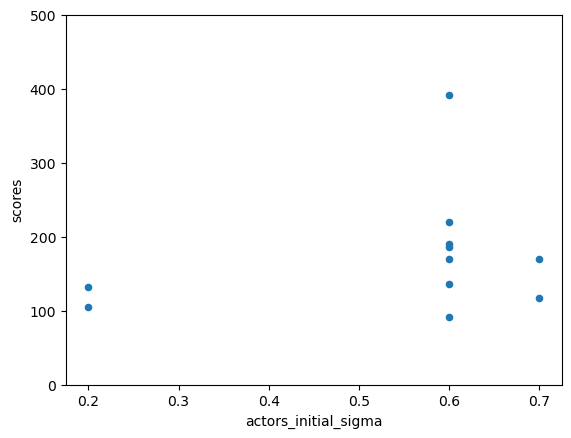

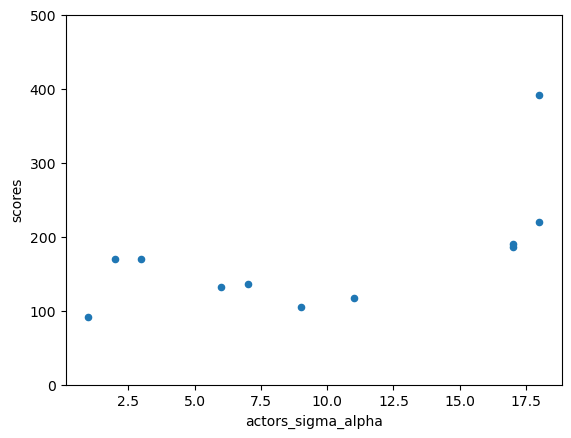

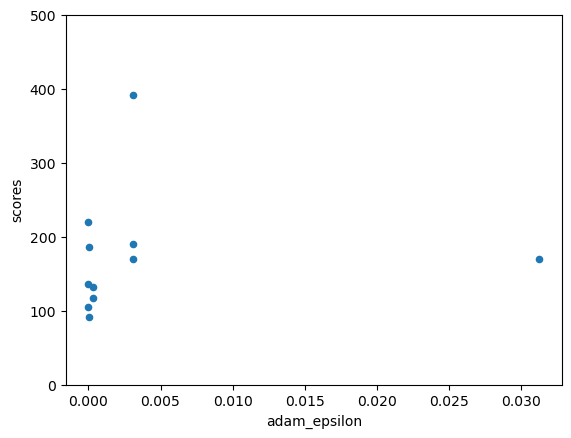

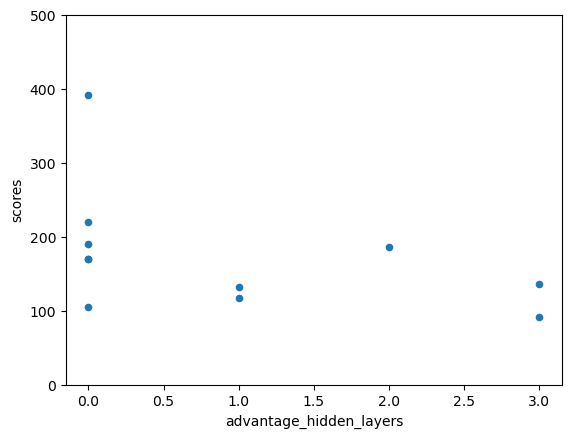

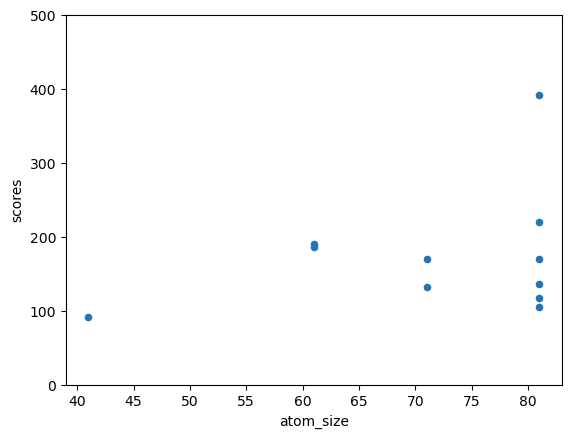

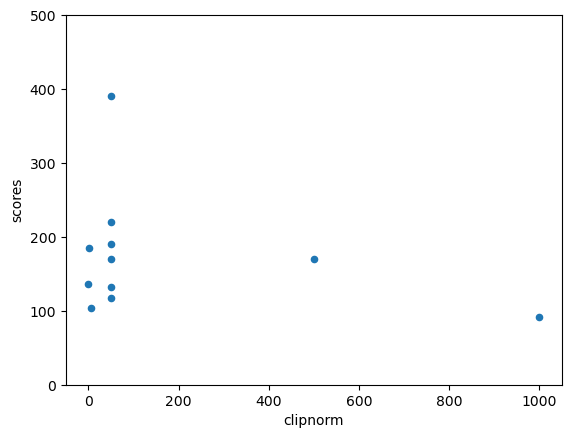

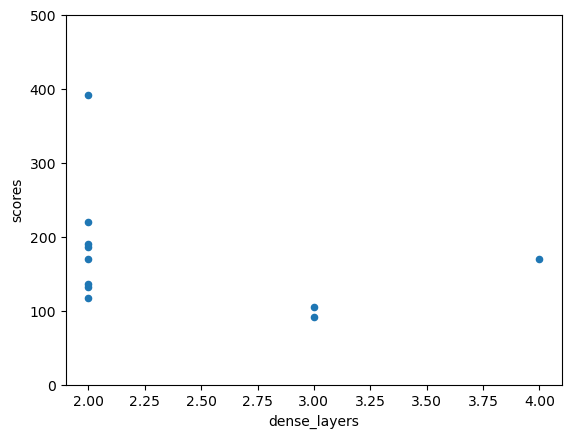

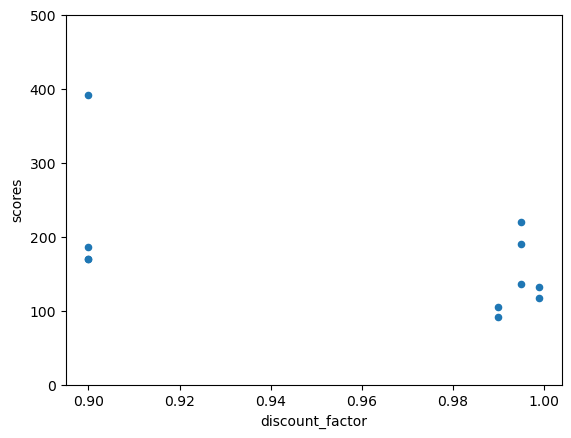

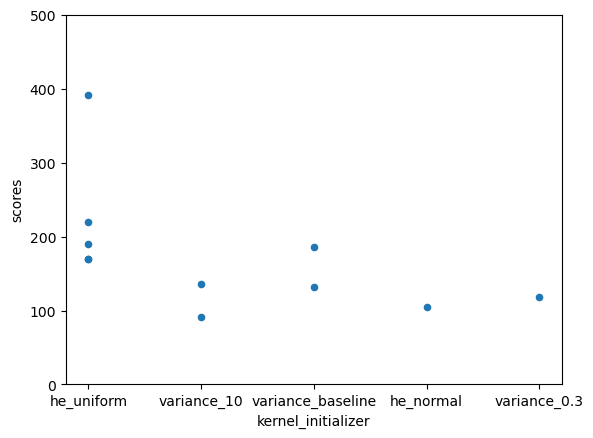

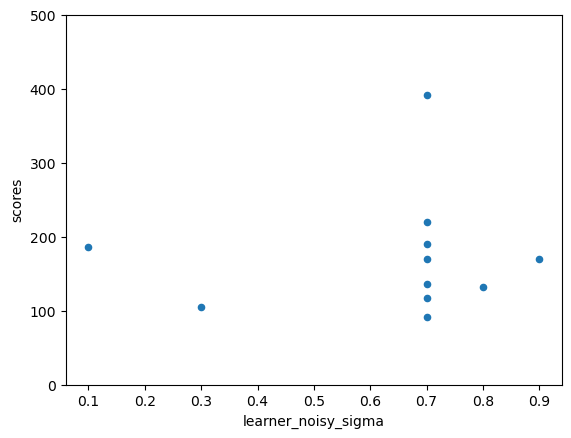

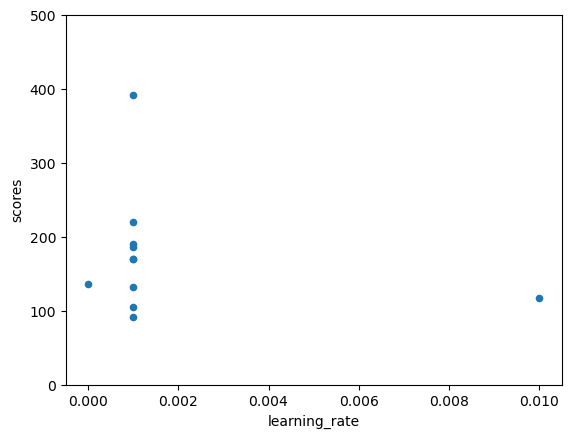

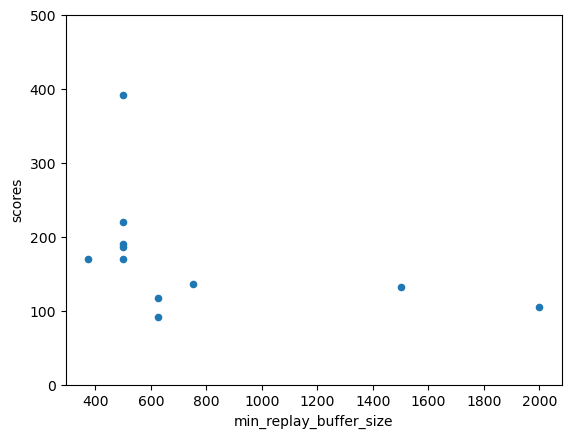

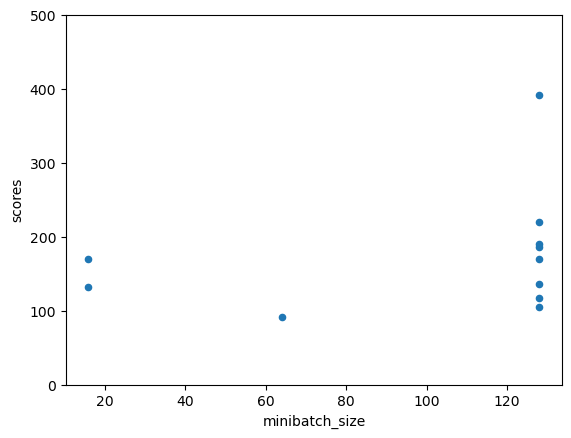

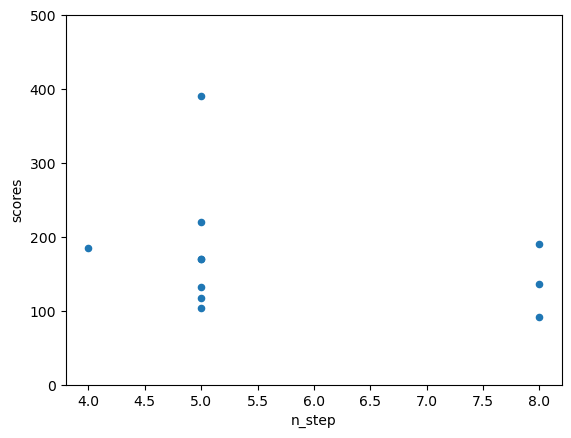

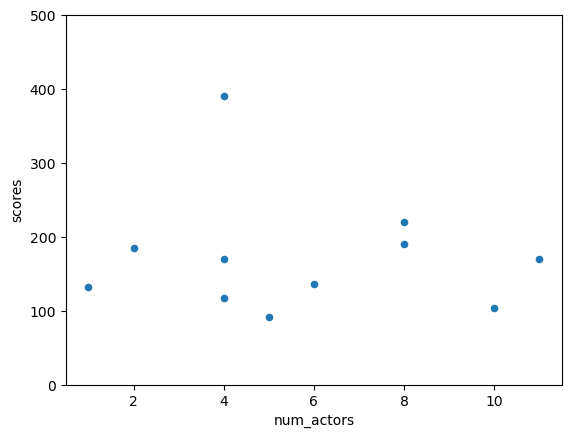

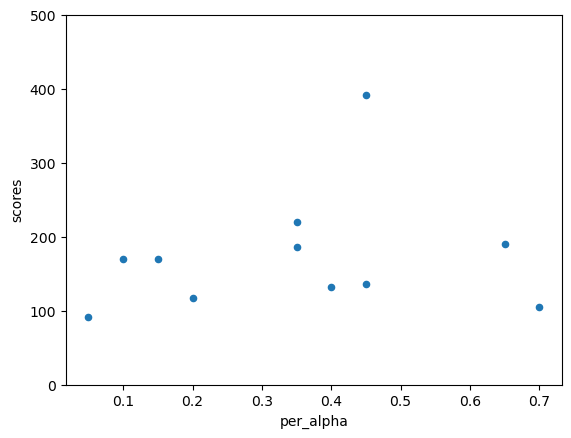

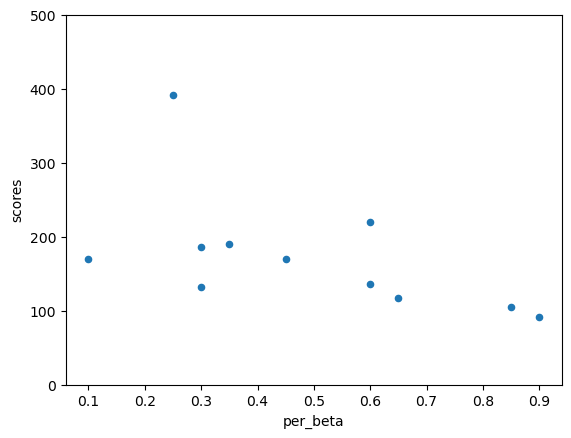

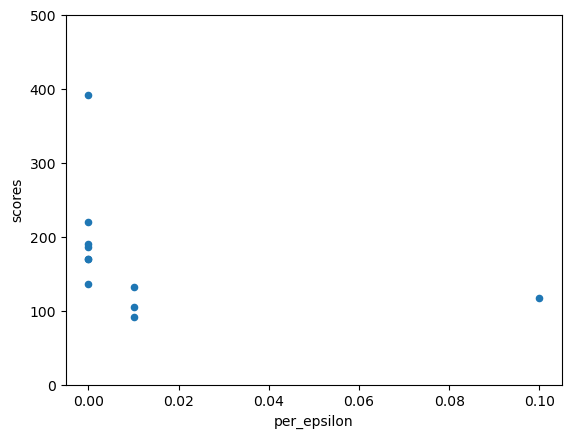

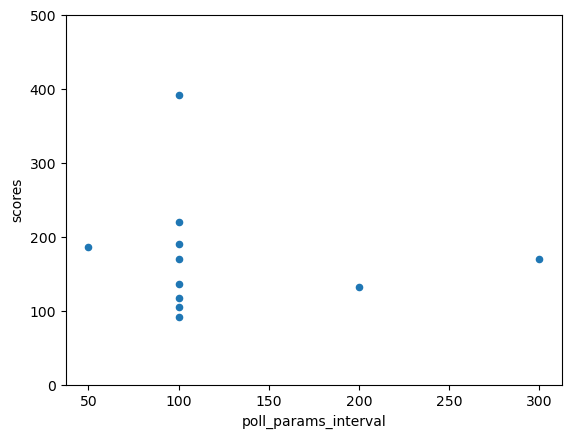

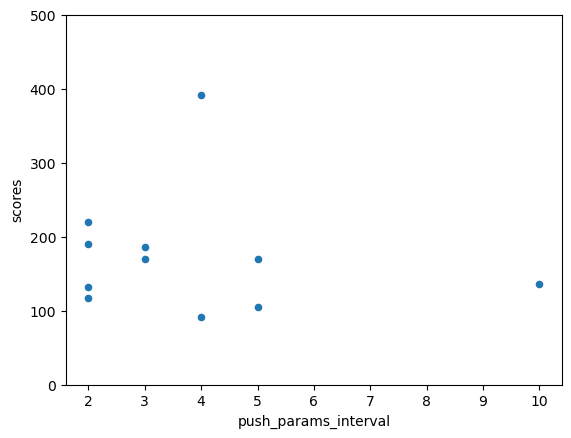

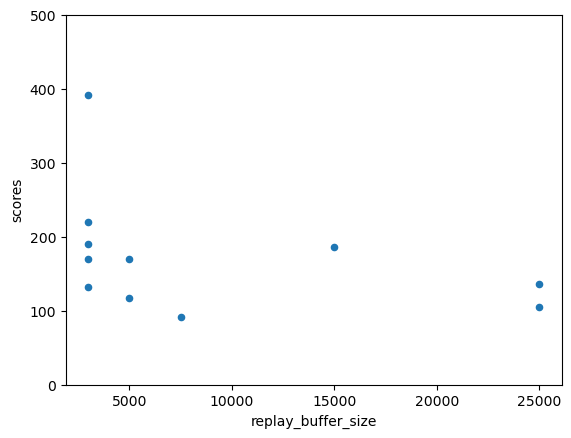

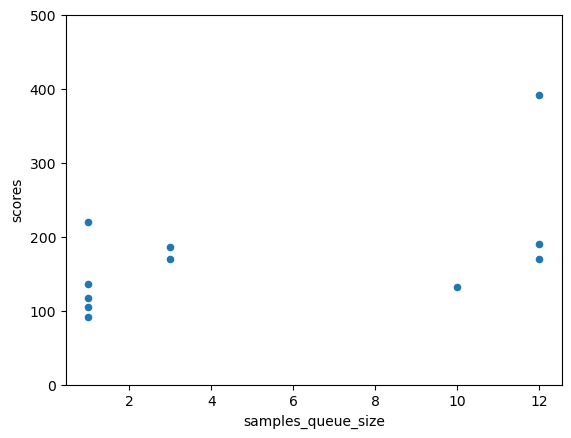

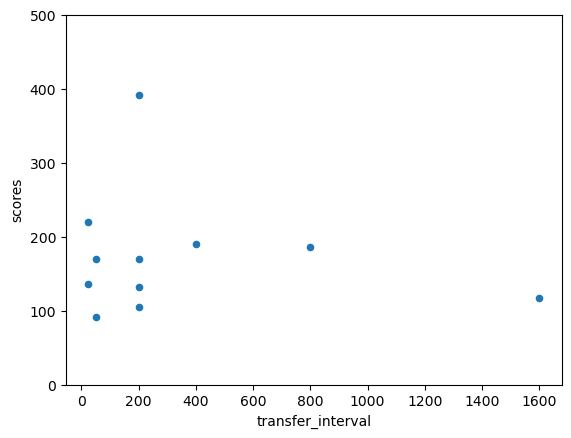

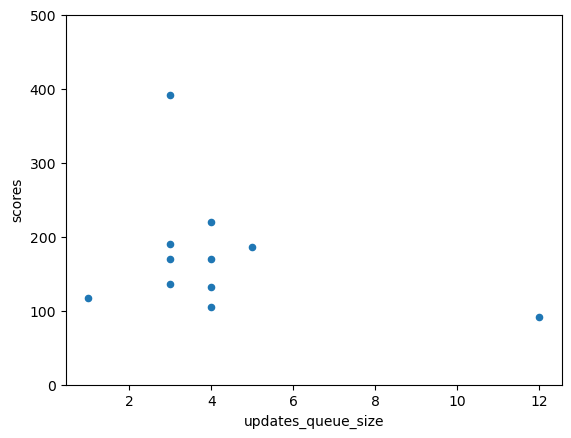

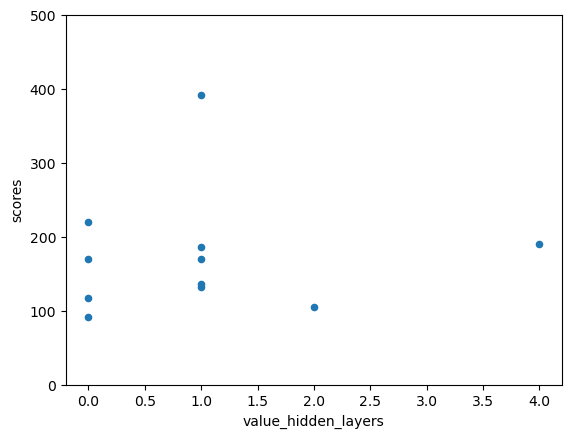

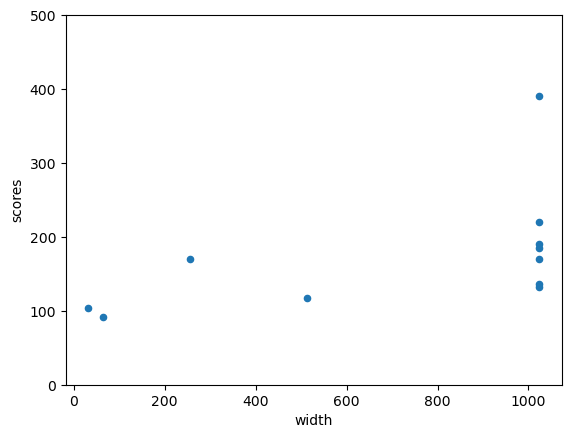

In [108]:
high_scores = df[df["scores"] > 100]

for col in x_cols:
  if col == "loss_function":
    continue
  high_scores.plot(x=col, y="scores", kind="scatter", ylim=(0, 500))


